In [1]:
import trimesh
import numpy as np
import torch
from sample import *
from hermite_spline import *
from unet import *
from torch.optim import Adam, LBFGS
from tqdm import tqdm

In [ ]:
import pandas as pd

fields = ['vel_x', 'vel_y', 'vel_z', 'press', 'temp']

for field in fields:
    df2 = pd.read_csv(f'../data/dp0/CFX/CFX/{field}.csv', skiprows=6)
    np.save(f'./preProcessedData/dp0/{field}.npy', df2.to_numpy())

fields = ['vel_x', 'vel_y', 'vel_z']

for field in fields:
    df2 = pd.read_csv(f'../dp0/CFX/CFX/{field}_inlet.csv', skiprows=6)
    np.save(f'./preProcessedData/dp0/{field}_inlet.npy', df2.to_numpy())


In [2]:
obj = trimesh.load("./Baseline_ML4Science.stl")
grid_resolution = np.array([64,32,16])
step = torch.tensor(obj.bounding_box.extents/(grid_resolution-1))

In [3]:
import trimesh
import numpy as np

# Load the mesh
obj = trimesh.load("./Baseline_ML4Science.stl")

# Get vertex coordinates
vertices = obj.vertices

# Get the x-coordinates of the vertices
x_coords = vertices[:, 0]

print(x_coords.max())

# Find the inlet (x = 0) and outlet (x = max(x))
inlet_faces = obj.faces[np.all(np.isclose(vertices[obj.faces][:, :, 0], 0, atol=1e-6), axis=1)]
outlet_faces = obj.faces[np.all(np.isclose(vertices[obj.faces][:, :, 0], x_coords.max(), atol=1e-6), axis=1)]

# Calculate the area for inlet and outlet
inlet_area = obj.submesh([np.where(np.isin(obj.faces, inlet_faces).all(axis=1))[0]], only_watertight=False)[0].area
outlet_area = obj.submesh([np.where(np.isin(obj.faces, outlet_faces).all(axis=1))[0]], only_watertight=False)[0].area

print(f"Inlet area (x=0): {inlet_area}")
print(f"Outlet area (x=max): {outlet_area}")

953.0
Inlet area (x=0): 3862.21921840575
Outlet area (x=max): 3806.2492232783748


In [4]:
device = 'cpu'
binary_mask = get_binary_mask(obj, grid_resolution)
unet_model = UNet3D().to(device)
optim = Adam(unet_model.parameters(), lr = 1e-3)
unet_input = prepare_mesh_for_unet(binary_mask)

In [22]:
spline_coeff = unet_model(unet_input)[0]
points = torch.tensor(trimesh.sample.volume_mesh(obj, 100))
points.requires_grad_(True)
x_support, y_support, z_support = get_support_points(points)

NameError: name 'get_support_points' is not defined

In [6]:
def sample_points(
    num_volume_points, num_inlet_surface_points, num_other_surface_points, shuffle=True
):
    # Prepare the sample points
    inlet_surface_points, inlet_surface_labels = get_inlet_surface_points(
        obj, num_inlet_surface_points
    )
    other_surface_points, other_surface_labels = get_other_surface_points(
        obj, num_other_surface_points
    )
    volume_points, volume_labels = get_volume_points(obj, num_volume_points)

    # Combine points and labels
    all_points = torch.cat(
        [inlet_surface_points, other_surface_points, volume_points], dim=0
    )
    all_labels = torch.cat(
        [inlet_surface_labels, other_surface_labels, volume_labels], dim=0
    )

    if shuffle:
        permutation = torch.randperm(all_points.size(0))
        return all_points[permutation], all_labels[permutation]
    return all_points, all_labels

In [7]:
train_points, train_labels = sample_points(1000, 200, 800)

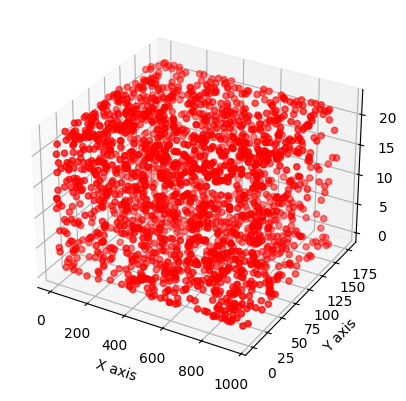

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_points[:,0], train_points[:,1], train_points[:,2], c='r', marker='o')  # Scatter plot with red dots

# Label axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show plot
plt.show()

[1 1 1]
tensor([15.1270,  5.7097,  1.4956], dtype=torch.float64)


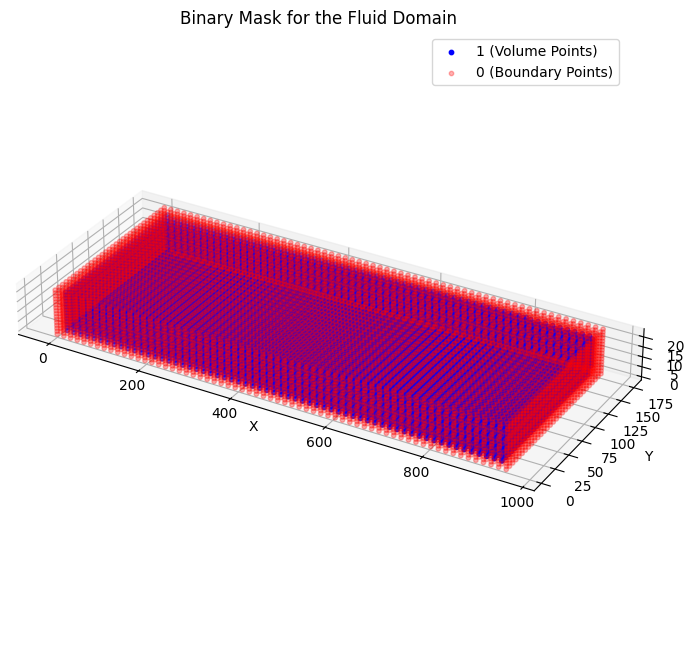

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D matrix with 1s and 0s
matrix = binary_mask
# Get the indices of 1s and 0s
ones = np.argwhere(matrix == 1)

print(ones[0])

# ones = torch.tensor(ones, dtype=torch.double)@step.T
ones = torch.tensor(ones, dtype=torch.double)*step
print(ones[0])

zeros = np.argwhere(matrix == 0)
zeros = torch.tensor(zeros, dtype=torch.double)*step

# Plot the matrix
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points where the matrix is 1 (blue points)
ax.scatter(ones[:, 0], ones[:, 1], ones[:, 2], c='blue', label='1 (Volume Points)', s=10)

# Plot points where the matrix is 0 (red points)
ax.scatter(zeros[:, 0], zeros[:, 1], zeros[:, 2], c='red', label='0 (Boundary Points)', s=10, alpha=0.3)

ax.set_box_aspect([1000, 400, 100])  # Aspect ratio matching original scale


# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Binary Mask for the Fluid Domain')
ax.legend()

$g(x, y, z) = \sum_{\substack{i,j,k \in [0:1] \times [0:1] \times [0:1] \\ \hat{x}, \hat{y}, \hat{z} \in \hat{X} \times \hat{Y} \times \hat{T}}} C_{x,y,z}^{i,j,k,l,m,n} h(\hat{x}-x, \hat{y}-y, \hat{z}-z)$

$g(x, y, z) = \sum_{\substack{i,j,k \in [0:1] \times [0:1] \times [0:1] \\ \hat{x}, \hat{y}, \hat{z} \in Enclosing Grid Points(1 to 8)}} C_{x,y,z}^{i,j,k,l,m,n} h(x - \hat{x}, y - \hat{y}, z - \hat{z})$

In [32]:
import numpy as np
import plotly.graph_objects as go

# Create a 3D matrix with 1s and 0s
matrix = binary_mask

# Get the indices of 1s and 0s
ones = np.argwhere(matrix == 1)
zeros = np.argwhere(matrix == 0)

# Create a scatter plot for 1s and 0s
trace_ones = go.Scatter3d(
    x=ones[:, 0],
    y=ones[:, 1],
    z=ones[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='1'
)

trace_zeros = go.Scatter3d(
    x=zeros[:, 0],
    y=zeros[:, 1],
    z=zeros[:, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='0'
)

# Combine traces
fig = go.Figure(data=[trace_ones, trace_zeros])

# Add layout details
fig.update_layout(
    title="Interactive 3D Matrix Visualization",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# Show the interactive plot
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
for i in range(3):
    spline_coeff = unet_model(unet_input)[0]

    points = torch.tensor(trimesh.sample.volume_mesh(obj, 100))
    points.requires_grad_(True)

    x_support, y_support, z_support = get_support_points(points)

    vx = get_field(spline_coeff, 0, points, x_support, y_support, z_support, step, basis_functions)
    vy = get_field(spline_coeff, 1, points, x_support, y_support, z_support, step, basis_functions)
    vz = get_field(spline_coeff, 2, points, x_support, y_support, z_support, step, basis_functions)
    p = get_field(spline_coeff, 3, points, x_support, y_support, z_support, step, basis_functions)
    
    vx_x = get_field(spline_coeff, 0, points, x_support, y_support, z_support, step, basis_functions, 1, 0, 0)
    vx_y = get_field(spline_coeff, 0, points, x_support, y_support, z_support, step, basis_functions, 0, 1, 0)
    vx_z = get_field(spline_coeff, 0, points, x_support, y_support, z_support, step, basis_functions, 0, 0, 1)

    vy_x = get_field(spline_coeff, 1, points, x_support, y_support, z_support, step, basis_functions, 1, 0, 0)
    vy_y = get_field(spline_coeff, 1, points, x_support, y_support, z_support, step, basis_functions, 0, 1, 0)
    vy_z = get_field(spline_coeff, 1, points, x_support, y_support, z_support, step, basis_functions, 0, 0, 1)
    
    vz_x = get_field(spline_coeff, 2, points, x_support, y_support, z_support, step, basis_functions, 1, 0, 0)
    vz_y = get_field(spline_coeff, 2, points, x_support, y_support, z_support, step, basis_functions, 0, 1, 0)
    vz_z = get_field(spline_coeff, 2, points, x_support, y_support, z_support, step, basis_functions, 0, 0, 1)
    
    p_x = get_field(spline_coeff, 3, points, x_support, y_support, z_support, step, basis_functions, 1, 0, 0)
    p_y = get_field(spline_coeff, 3, points, x_support, y_support, z_support, step, basis_functions, 0, 1, 0)
    p_z = get_field(spline_coeff, 3, points, x_support, y_support, z_support, step, basis_functions, 0, 0, 1)
    
    vx_xx = get_field(spline_coeff, 0, points, x_support, y_support, z_support, step, basis_functions, 2, 0, 0)
    vx_yy = get_field(spline_coeff, 0, points, x_support, y_support, z_support, step, basis_functions, 0, 2, 0)
    vx_zz = get_field(spline_coeff, 0, points, x_support, y_support, z_support, step, basis_functions, 0, 0, 2)
    
    vy_xx = get_field(spline_coeff, 1, points, x_support, y_support, z_support, step, basis_functions, 2, 0, 0)
    vy_yy = get_field(spline_coeff, 1, points, x_support, y_support, z_support, step, basis_functions, 0, 2, 0)
    vy_zz = get_field(spline_coeff, 1, points, x_support, y_support, z_support, step, basis_functions, 0, 0, 2)
    
    vz_xx = get_field(spline_coeff, 2, points, x_support, y_support, z_support, step, basis_functions, 2, 0, 0)
    vz_yy = get_field(spline_coeff, 2, points, x_support, y_support, z_support, step, basis_functions, 0, 2, 0)
    vz_zz = get_field(spline_coeff, 2, points, x_support, y_support, z_support, step, basis_functions, 0, 0, 2)
    
    rho = 1.010427
    mu = 2.02e-5
    loss_divergence = torch.mean((vx_x + vy_y + vz_z)**2)
    loss_momentum_x = torch.mean((vx*vx_x + vy*vx_y + vz*vx_z + (1/rho)*p_x - (mu/rho)*(vx_xx + vx_yy + vx_zz))**2)
    loss_momentum_y = torch.mean((vx*vy_x + vy*vy_y + vz*vy_z + (1/rho)*p_y - (mu/rho)*(vy_xx + vy_yy + vy_zz))**2)
    loss_momentum_z = torch.mean((vx*vz_x + vy*vz_y + vz*vz_z + (1/rho)*p_z - (mu/rho)*(vz_xx + vz_yy + vz_zz))**2)

    loss = loss_divergence + 10.0*loss_momentum_x + 10.0*loss_momentum_y + 10.0*loss_momentum_z
    print(f'Loss: {loss_divergence.item()}, {loss_momentum_x.item()}, {loss_momentum_y.item()}, {loss_momentum_z.item()}')
    optim.zero_grad()
    loss.backward()
    optim.step()

Loss: 0.3221743702888489, 0.17541548609733582, 0.22631408274173737, 0.22136251628398895
Loss: 0.430877149105072, 0.3643985688686371, 0.22490420937538147, 0.218585804104805


KeyboardInterrupt: 

In [ ]:
from sample import *

In [22]:
def get_supoort_points(points):
    x = points[:,0]
    y = points[:,1]
    z = points[:,2]
    x_floor = (x//step[0]).long()
    y_floor = (y//step[1]).long()
    z_floor = (z//step[2]).long()
    x_support_indices = torch.vstack((x_floor, torch.clamp(x_floor+1,max=grid_resolution[0]-1)))
    y_support_indices = torch.vstack((y_floor, torch.clamp(y_floor+1,max=grid_resolution[1]-1)))
    z_support_indices = torch.vstack((z_floor, torch.clamp(z_floor+1,max=grid_resolution[2]-1)))
    return x,y,z,x_support_indices,y_support_indices,z_support_indices

def f(spline_coeff, channel,points,der_x=0,der_y=0,der_z=0):
    x,y,z,x_support_indices,y_supports_indices,z_supports_indices = get_supoort_points(points)
    conv_sum = 0
    for type in range(spline_coeff[channel].shape[0]):
        i, j, k = binary_array(type)
        spline_coeff_ijk = spline_coeff[channel][type]
        for x_support_ind in x_support_indices:
            for y_support_ind in y_supports_indices:
                for z_support_ind in z_supports_indices:
                    # One of the 8 grid support points(enclosing cube vertices) for each sample point.
                    support_point_ind = torch.vstack((x_support_ind,y_support_ind,z_support_ind)).T

                    x_indices = support_point_ind[:, 0]
                    y_indices = support_point_ind[:, 1]
                    z_indices = support_point_ind[:, 2]

                    x_input = (x-x_indices*step[0])/step[0]
                    y_input = (y-y_indices*step[1])/step[1]
                    z_input = (z-z_indices*step[2])/step[2]
                    
                    conv_sum += (spline_coeff_ijk[x_indices, y_indices, z_indices]) * hermite_kernel_3d(i,j,k,x_input,y_input,z_input,der_x,der_y,der_z)
    return conv_sum

In [23]:
obj = trimesh.load("Baseline_ML4Science.stl")

grid_resolution = np.array([20,20,20])
binary_mask = get_binary_mask(obj, grid_resolution)
step = obj.bounding_box.extents/(grid_resolution-1)

# Instantiate the neural network
unet_model = UNet3D().to(device)
optimizer = Adam(unet_model.parameters(), lr = 1e-3)
unet_model.apply(initialize_weights)

UNet3D(
  (enc1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d

In [26]:
def get_binary_mask(model, grid_resolution):
    bounds = model.bounds
    min_bound, max_bound = bounds[0], bounds[1]
    x = np.linspace(min_bound[0], max_bound[0], grid_resolution[0])
    y = np.linspace(min_bound[1], max_bound[1], grid_resolution[1])
    z = np.linspace(min_bound[2], max_bound[2], grid_resolution[2])
    xx, yy, zz = np.meshgrid(x, y, z)
    grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
    inside_points = grid_points[model.contains(grid_points)]
    binary_volume = np.zeros(grid_resolution, dtype=np.uint8)
    for point in inside_points:
        # Compute the index of the point in the grid
        index_x = np.searchsorted(x, point[0])
        index_y = np.searchsorted(y, point[1])
        index_z = np.searchsorted(z, point[2])
        # Set the corresponding position in the binary volume to 1
        if (
            0 <= index_x < grid_resolution[0]
            and 0 <= index_y < grid_resolution[1]
            and 0 <= index_z < grid_resolution[2]
        ):
            binary_volume[index_x, index_y, index_z] = 1
    return binary_volume

def get_inlet_surface_points(obj, num_points):
    threshold = 1e-5
    faces_x_zero = [
        i for i, face in enumerate(obj.faces)
        if np.all(np.abs(obj.vertices[face, 0]) < threshold)  # Check if all vertices' x-coordinates are 0
    ]
    subset_mesh = obj.submesh([faces_x_zero], only_watertight=False)[0]
    points, _ = trimesh.sample.sample_surface(subset_mesh, count=num_points)
    inlet_surface_points = torch.tensor(points / 1000.0, dtype = torch.float64)
    inlet_surface_labels = torch.ones(inlet_surface_points.size(0), dtype=torch.int64)
    return inlet_surface_points, inlet_surface_labels

def get_other_surface_points(obj, num_points):
    threshold = 1e-5
    points, _ = trimesh.sample.sample_surface(obj, count=num_points)
    filtered_points = points[np.abs(points[:, 0]) > threshold]
    other_surface_points = torch.tensor(filtered_points / 1000.0, dtype = torch.float64)
    other_surface_labels = 2*torch.ones(other_surface_points.size(0), dtype=torch.int64)
    return other_surface_points, other_surface_labels

def get_volume_points(obj, num_points):
    volume_points = torch.tensor(trimesh.sample.volume_mesh(obj, num_points) / 1000.0, dtype=torch.float64)
    volume_labels = torch.zeros(volume_points.size(0), dtype=torch.int64)
    return volume_points, volume_labels

In [36]:
from sample import *

# inlet_surface_points, inlet_surface_labels = get_inlet_surface_points(obj,100)
# other_surface_points, other_surface_labels = get_other_surface_points(obj,400)   
volume_points, volume_labels = get_volume_points(obj,500)   

volume_points.requires_grad_(True)

# Get Hermite Spline coefficients from the Unet
unet_input = prepare_mesh_for_unet(binary_mask)
spline_coeff = unet_model(unet_input)[0]

In [50]:
%timeit vx1 = f(spline_coeff,0,volume_points,0,0,0)

7.04 ms ± 78.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
def binary_array(n):
    if n < 0 or n > 7:
        raise ValueError("Number must be between 0 and 7 inclusive.")
    # Convert the number to a binary string, remove the '0b' prefix, and pad it to 3 bits
    binary_str = format(n, '03b')
    binary_array = [int(bit) for bit in binary_str]
    return binary_array[0], binary_array[1], binary_array[2]

# Hermite Spline Kernels for 2nd Order
def h0(diff, der = 0):
    abs_diff = torch.abs(diff)
    match der:
        case 0:
            return (1-abs_diff)**2*(1+2*abs_diff)
        case 1:
            return 6*diff*(abs_diff-1)
        case 2:
            return 12*abs_diff-6

def h1(diff, der = 0):
    abs_diff = torch.abs(diff)
    match der:
        case 0:
            return diff*(1-abs_diff)**2
        case 1:
            return 3*abs_diff**2 - 4*abs_diff + 1
        case 2:
            return 6*diff - 4*abs_diff

hermite_kernel_1d = [h0, h1]

def hermite_kernel_3d(i,j,k,x,y,z,der_x=0,der_y=0,der_z=0):
    return hermite_kernel_1d[i](x, der_x) * hermite_kernel_1d[j](y, der_y) * hermite_kernel_1d[k](z, der_z)

In [46]:
def h_000(x):
    return h0(x[0])*h0(x[1])*h0(x[2])

def h_001(x):
    return h0(x[0])*h0(x[1])*h1(x[2])

def h_010(x):
    return h0(x[0])*h1(x[1])*h0(x[2])

def h_011(x):
    return h0(x[0])*h1(x[1])*h1(x[2])

def h_100(x):
    return h1(x[0])*h0(x[1])*h0(x[2])

def h_101(x):
    return h1(x[0])*h0(x[1])*h1(x[2])

def h_110(x):
    return h1(x[0])*h1(x[1])*h0(x[2])

def h_111(x):
    return h1(x[0])*h1(x[1])*h1(x[2])


hs = [h_000, h_001, h_010, h_011, h_100, h_101, h_110, h_111]

def get_field(coefficients, field_idx, points, x_support, y_support, z_support, step, der_x = 0, der_y = 0, der_z = 0):
    field = torch.zeros(points.shape[0])
    for l, p in enumerate(points):
        # Get 8 points of the cube
        # print(x_support[0, l], x_support[1, l])
        x_indices = torch.arange(x_support[0, l], x_support[1, l] + 1)  # x range
        y_indices = torch.arange(y_support[0, l], y_support[1, l] + 1)  # y range
        z_indices = torch.arange(z_support[0, l], z_support[1, l] + 1)  # z range
        x_coords = x_indices * step[0]
        y_coords = y_indices * step[1]
        z_coords = z_indices * step[2]
        # Generate all combinations of grid coordinates
        xx, yy, zz = torch.meshgrid(x_coords, y_coords, z_coords, indexing="ij")
        grid_points = torch.stack([xx.flatten(), yy.flatten(), zz.flatten()], dim=1) # 8x3
        h_points = torch.tensor([[h((p-x)/step) for h in hs] for x in grid_points])
        coeff = coefficients[field_idx, :, x_support[0, l]:x_support[1, l]+1, y_support[0, l]:y_support[1, l]+1, z_support[0, l]:z_support[1, l]+1]
        field[l] = torch.sum(coeff.flatten()*h_points.flatten())
    return field

x,y,z,x_support_indices,y_supports_indices,z_supports_indices = get_supoort_points(volume_points)

vx2 = get_field(spline_coeff, 0, volume_points, x_support_indices, y_supports_indices, z_supports_indices, torch.tensor(step))

In [49]:
%timeit vx2 = get_field(spline_coeff, 0, volume_points, x_support_indices, y_supports_indices, z_supports_indices, torch.tensor(step))

1.56 s ± 8.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
vx1

tensor([0.1611, 0.1548, 0.1581, 0.1551, 0.1614, 0.1613, 0.1575, 0.1623, 0.1610,
        0.1580, 0.1598, 0.1583, 0.1589, 0.1553, 0.1550, 0.1577, 0.1602, 0.1610,
        0.1575, 0.1572, 0.1572, 0.1610, 0.1571, 0.1599, 0.1548, 0.1584, 0.1627,
        0.1624, 0.1600, 0.1574, 0.1570, 0.1557, 0.1601, 0.1618, 0.1602, 0.1593,
        0.1609, 0.1602, 0.1559, 0.1590, 0.1621, 0.1598, 0.1617, 0.1609, 0.1600,
        0.1589, 0.1610, 0.1609, 0.1597, 0.1597, 0.1621, 0.1565, 0.1625, 0.1560,
        0.1591, 0.1583, 0.1601, 0.1585, 0.1592, 0.1615, 0.1554, 0.1534, 0.1603,
        0.1549, 0.1542, 0.1598, 0.1579, 0.1587, 0.1615, 0.1569, 0.1618, 0.1570,
        0.1640, 0.1561, 0.1544, 0.1612, 0.1598, 0.1559, 0.1601, 0.1553, 0.1593,
        0.1592, 0.1608, 0.1595, 0.1579, 0.1597, 0.1562, 0.1566, 0.1582, 0.1618,
        0.1571, 0.1592, 0.1618, 0.1584, 0.1547, 0.1608, 0.1565, 0.1556, 0.1584,
        0.1574, 0.1569, 0.1577, 0.1592, 0.1545, 0.1588, 0.1619, 0.1614, 0.1555,
        0.1587, 0.1616, 0.1600, 0.1556, 